In [4]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import keras_tuner as kt
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [6]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [7]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)

Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


In [ ]:
## Estimación de los hiperparámetros del compilador

def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  augmentation = Sequential([
        RandomFlip()
  ])
  base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg')
  base_model.trainable = False
  entrada = Input(shape=(224,224,3))
  prediction_layer = Dense(29, activation="softmax")
  model = Sequential([
    entrada,
    augmentation,
    base_model,
    BatchNormalization(),
    Dropout(0.2),
    prediction_layer
  ])

  # Tuneamos el learning rate y el optimizador
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4,0.1,
                                                        0.2, 0.3])
  hp_amsgrad = hp.Choice('amsgrad', values=[True,False])
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate,amsgrad=hp_amsgrad),
                loss=SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  return model

# Instanciamos el tuner
tuner = kt.Hyperband(model_builder, 
                     objective='val_accuracy', 
                     max_epochs=25,
                     factor=3, 
                     directory="/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/",
                     project_name='khyperbandEfficientNetB2')

print(tuner.search_space_summary())

# Ejecutamos el tuner
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(training,validation_data=validation,epochs=25, callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]

print(best_hp.get('learning_rate'))
print(best_hp.get('amsgrad'))

Trial 18 Complete [00h 17m 02s]
val_accuracy: 0.7588894367218018

Best val_accuracy So Far: 0.7588894367218018
Total elapsed time: 01h 54m 20s
INFO:tensorflow:Oracle triggered exit


Epoch 1/25
257/257 [==============================] - 79s 265ms/step - loss: 1.6528 - accuracy: 0.5119 - val_loss: 1.2944 - val_accuracy: 0.6444
Epoch 2/25
257/257 [==============================] - 64s 248ms/step - loss: 1.0919 - accuracy: 0.6442 - val_loss: 0.9359 - val_accuracy: 0.6912
Epoch 3/25
257/257 [==============================] - 64s 248ms/step - loss: 0.9509 - accuracy: 0.6851 - val_loss: 0.9230 - val_accuracy: 0.6961
Epoch 4/25
257/257 [==============================] - 64s 248ms/step - loss: 0.8842 - accuracy: 0.7042 - val_loss: 0.8296 - val_accuracy: 0.7350
Epoch 5/25
257/257 [==============================] - 64s 246ms/step - loss: 0.8345 - accuracy: 0.7223 - val_loss: 0.8034 - val_accuracy: 0.7350
Epoch 6/25
257/257 [==============================] - 64s 247ms/step - loss: 0.8009 - accuracy: 0.7286 - val_loss: 0.8150 - val_accuracy: 0.7219
Epoch 7/25
257/257 [==============================] - 64s 247ms/step - loss: 0.7774 - accuracy: 0.7374 - val_loss: 0.8111 - val_ac

2022/03/18 15:25:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


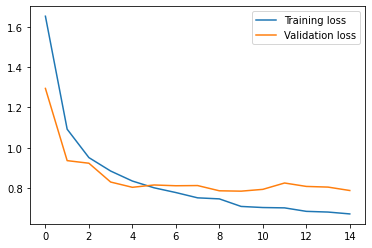

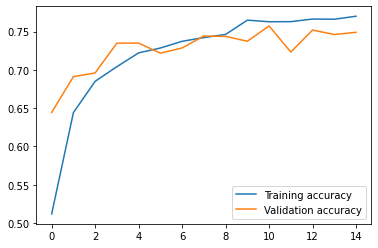

In [9]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip()
])


## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                  weights='imagenet',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  augmentation,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=0.001, amsgrad=0)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB2 con DataAugmentation (ImageNet)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/25
257/257 [==============================] - 257s 930ms/step - loss: 1.3353 - accuracy: 0.6161 - val_loss: 1.8928 - val_accuracy: 0.4705
Epoch 2/25
257/257 [==============================] - 234s 909ms/step - loss: 0.6761 - accuracy: 0.7817 - val_loss: 0.6780 - val_accuracy: 0.8183
Epoch 3/25
257/257 [==============================] - 237s 919ms/step - loss: 0.5247 - accuracy: 0.8278 - val_loss: 0.6384 - val_accuracy: 0.8485
Epoch 4/25
257/257 [==============================] - 235s 911ms/step - loss: 0.4220 - accuracy: 0.8551 - val_loss: 0.3754 - val_accuracy: 0.8773
Epoch 5/25
257/257 [==============================] - 234s 911ms/step - loss: 0.3378 - accuracy: 0.8838 - val_loss: 1.1817 - val_accuracy: 0.8665
Epoch 6/25
257/257 [==============================] - 235s 914ms/step - loss: 0.3158 - accuracy: 0.8877 - val_loss: 0.4770 - val_accuracy: 0.8880
Epoch 7/25
257/257 [==============================] - 236s 916ms/step - loss: 0.2620 - accuracy: 0.9084 - val_loss: 0.5584 -

2022/03/18 16:21:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


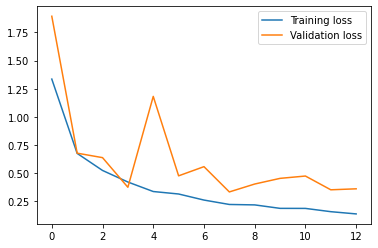

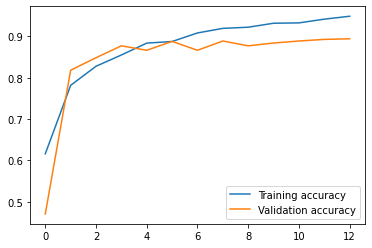

In [10]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
  for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = True

  opt = Adam(learning_rate=1e-4)
  model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
              metrics=['accuracy'])
  
unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [11]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [12]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB2_ImageNet.csv', index=False)
files.download('EfficientNetB2_ImageNet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>